In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.integrate import cumtrapz
from scipy.signal import savgol_filter
import sys, os, pickle, string
from autophasemap import plot_clusters
color_blindf = ["#3f90da", "#ffa90e", "#bd1f01", "#832db6", 
"#a96b59", "#e76300", "#b9ac70", "#92dadd", "#94a4a2"]
bkg_spectra_color = "#717581"
SAVE_DIR = "../../figures/blends/"

In [10]:
pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight'
              } 

In [11]:
with open('./data_smooth4.pkl', 'rb') as f:
    result = pickle.load(f)
    
n_clusters = 4


In [12]:
class DataSet:
    def __init__(self, C, q, Iq, N, n_domain=200):
        self.n_domain = n_domain
        self.t = np.linspace(0,1, num=self.n_domain)
        self.N = N
        self.Iq = Iq
        self.C = C
        self.q = q
        
    def generate(self, process=None):
        if process=="normalize":
            self.F = [self.Iq[i]/self.l2norm(self.Iq[i]) for i in range(self.N)]
        elif process=="smoothen":
            self.F = [self._smoothen(self.Iq[i,:]/self.l2norm(self.Iq[i])) for i in range(self.N)]
        elif process is None:
            self.F = [self.Iq[i] for i in range(self.N)]
            
        return
        
    def l2norm(self, f):
        norm = np.sqrt(np.trapz(f**2, data.t))
        
        return norm
    
    def _smoothen(self, f):
        f_hat = savgol_filter(f, 8, 3)
        
        return f_hat

saxs = np.load('../../expts/OMIECS/blends_WSCP_P123_NOpH.npz')

q = saxs['q']
n_domain = len(saxs['q'])

swap_c_columns = np.zeros_like(saxs['C'])
swap_c_columns[:,0] = saxs['C'][:,1] 
swap_c_columns[:,1] = saxs['C'][:,0] 
C = swap_c_columns
Iq = saxs['Iq']

N = C.shape[0]

data = DataSet(C, q, Iq, N, n_domain=n_domain)
data.generate(process="smoothen")
print('Number of functions : ', data.N)
print('Domain sampling of each function : ', n_domain)
print('Design space shape : ', data.C.shape)

Number of functions :  93
Domain sampling of each function :  1304
Design space shape :  (93, 2)


## Visualization for the paper

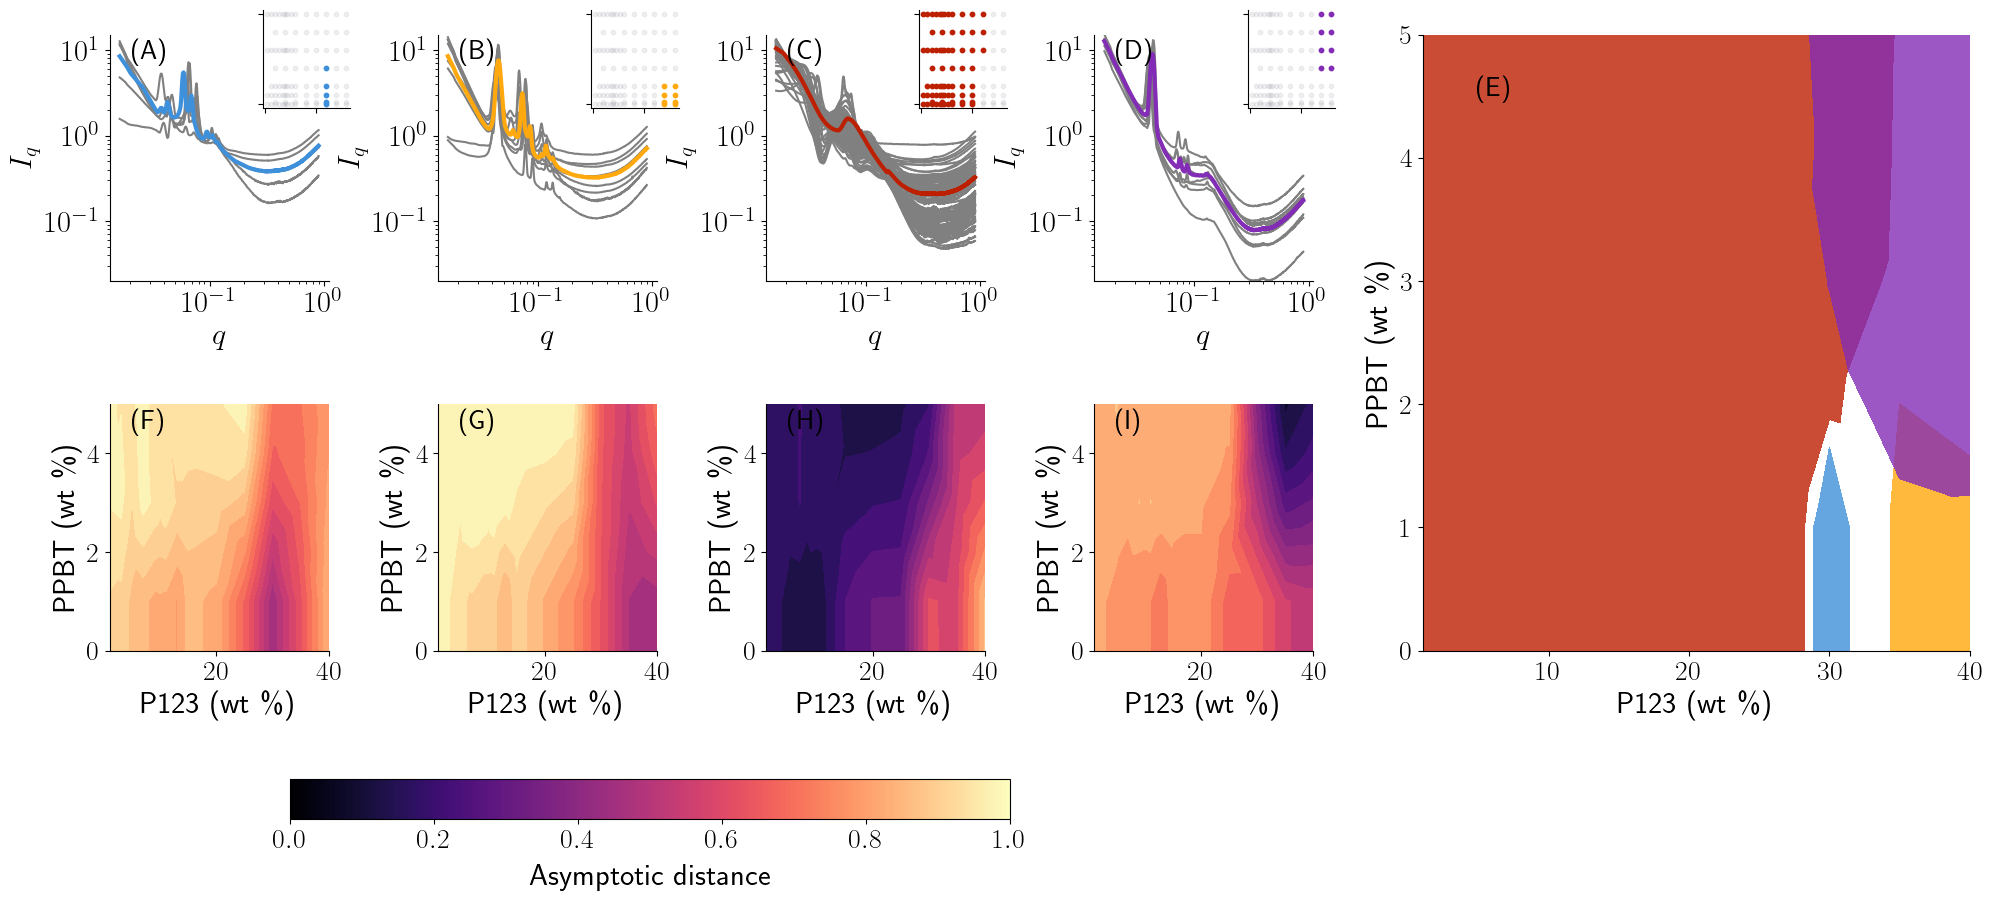

In [13]:
def setup_axs():
    layout = [['A1','A2', 'A3', 'A4', 'C', 'C'], 
              ['B1', 'B2', 'B3', 'B4', 'C', 'C']
              ]
    fig, axs = plt.subplot_mosaic(layout, figsize=(4*6, 4*2))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    for k, (_,ax) in enumerate(axs.items()):
        ax.text(0.1, 0.9, r'(%s)'%string.ascii_uppercase[k], 
        transform=ax.transAxes, 
        size=20, weight='bold'
        )
    return fig, axs

cmap = cm.get_cmap('magma')
norm = Normalize(vmin=0, vmax = 1)
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)


def plot_contours_distance(axs, data, result):
    for k, ax in enumerate(axs):
        dist = result['dist'][:,k]
        ax.tricontourf(data.C[:,0], 
                       data.C[:,1], 
                       dist,
                       15,
                       cmap=cmap,
                       norm = norm
                      )

        ax.set_xlabel('P123 (wt \%)', fontsize=22)
        ax.set_ylabel('PPBT (wt \%)', fontsize=22)
        ax.tick_params(labelsize=20)

    return 

with plt.style.context(pyplot_style):
    fig, axs = setup_axs()
    ax_clusters = [axs[k] for k in ['A1', 'A2', 'A3', 'A4']]
    plot_clusters(ax_clusters,data, result, mode="input")

    ax_contours = [axs[k] for k in ['B1', 'B2', 'B3', 'B4']]
    plot_contours_distance(ax_contours,data, result)

    norm = Normalize(vmin=0, vmax=1)
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    cax = fig.add_axes([0.2, -0.1, 0.3, 0.05])        
    cbar = fig.colorbar(mappable, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=20) 
    cbar.ax.set_xlabel('Asymptotic distance',
                    labelpad=8,
                    fontsize=22,
                    rotation='horizontal'
                    )

    ax_map = axs['C']
    for k in range(n_clusters):
        dist = result['dist'][:,k]
        ax_map.tricontourf(data.C[:,0], 
                    data.C[:,1],
                    dist,
                    levels=[0.0, 0.5],
                    colors=color_blindf[k],
                    alpha=0.8
                    )

    ax_map.set_xlabel('P123 (wt \%)', fontsize=22)
    ax_map.set_ylabel('PPBT (wt \%)', fontsize=22)
    ax_map.tick_params(labelsize=20)
    plt.savefig(SAVE_DIR+'full_template4.pdf')
    plt.show()

## Manual inspection of results

0 : [1.0, 1.1454545435531212, 1.5818181795754764, 1.8545454537653834, 2.545454543016822, 2.818181806480746]
1 : [1.0, 1.3283582089223698, 1.611940300347295, 1.8656716431052107, 2.5820895516802858]
2 : [1.0]
3 : [1.0, 1.7460317489301125, 2.01587301832548]


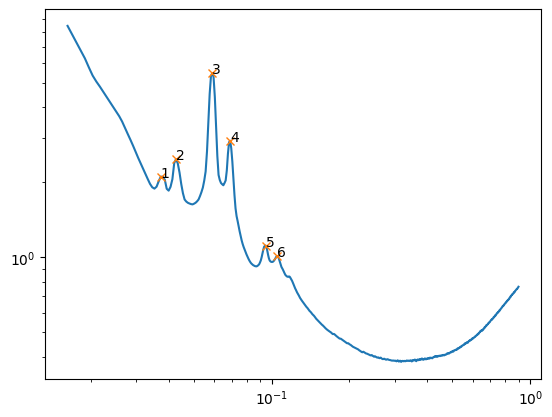

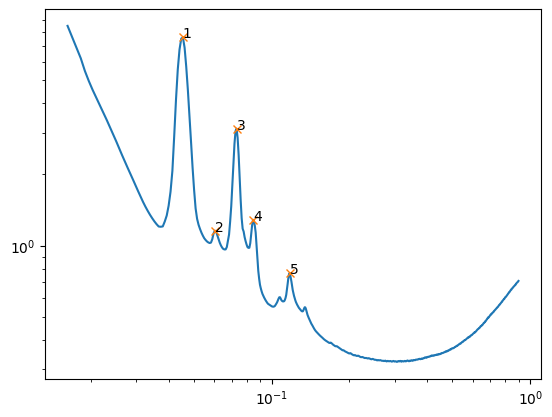

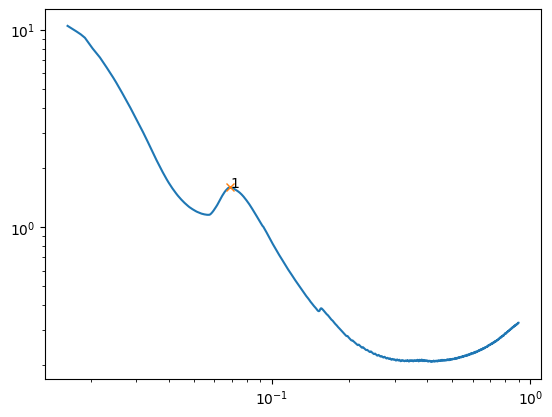

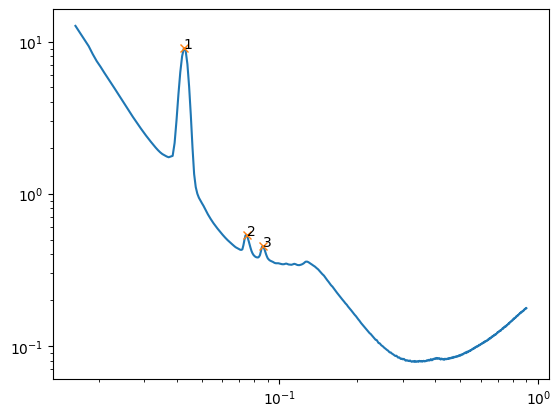

In [8]:
from scipy.signal import find_peaks

def peak_plot(q, y, ax, **kwargs):
    peaks, _ = find_peaks(y,**kwargs)
    ax.loglog(q, y)
    ax.loglog(q[peaks], y[peaks], 'x')
    for i, p in enumerate(peaks):
        ax.text(q[p], y[p], i+1)
        
    return q[peaks]
        
for i in range(n_clusters):
    fig, ax = plt.subplots()
    pk_kwargs = {'prominence':0.05, 'width':0.01}
    q_peaks = peak_plot(data.q, result['templates'][i],ax, **pk_kwargs)
    print(i, ':', [qp/q_peaks[0] for qp in q_peaks])

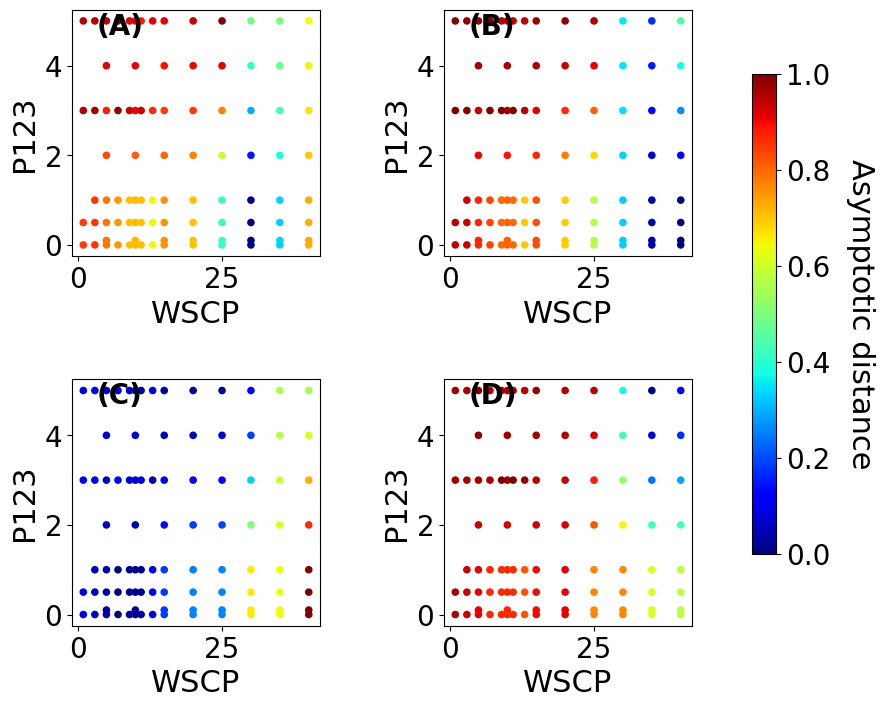

In [9]:
fig, axs = setup_axs()
for k, ax in enumerate(axs):
    cmap = cm.get_cmap('jet')
    ax.scatter(data.C[:,0], 
               data.C[:,1],
               c = result['dist'][:,k],
               cmap=cmap,
               s=20
              )
    ax.tick_params(labelsize=20)
    ax.set_xlabel(saxs['C_dim_names'][0], fontsize=22)
    ax.set_ylabel(saxs['C_dim_names'][1], fontsize=22)
    
norm = Normalize(vmin=0, vmax = 1)
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
cax = plt.axes([0.975, 0.2, 0.03, 0.6])        
cbar = fig.colorbar(mappable, cax=cax)
cbar.ax.tick_params(labelsize=20) 
cbar.ax.set_ylabel('Asymptotic distance', rotation=270, labelpad=32, fontsize=22)
plt.show()

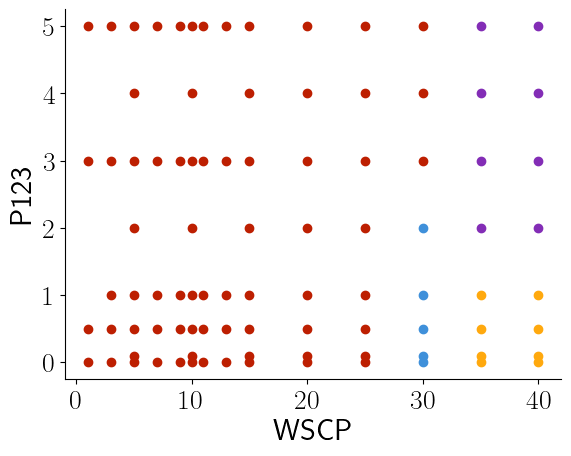

In [52]:
with plt.style.context(pyplot_style):
    cmap = plt.get_cmap("tab10")

    fig, ax = plt.subplots()
    for k in range(n_clusters):
        Mk = result['delta_n']==k
        ax.scatter(data.C[Mk,0], 
                   data.C[Mk,1],
                   color = color_blindf[k], 
                   alpha=1.0
                  )   
        
ax.set_xlabel(saxs['C_dim_names'][0], fontsize=22)
ax.set_ylabel(saxs['C_dim_names'][1], fontsize=22)
ax.tick_params(labelsize=20)
plt.show()

In [41]:
from scipy.spatial import Delaunay
import numpy as np

# take from : https://stackoverflow.com/a/50714300
def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add an edge between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
            
    return edges

Could not plot 0


/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_1180/2101226154.py:7: DeprecationWarning: Delaunay attribute 'vertices' is deprecated in favour of 'simplices' and will be removed in Scipy 1.11.0.
  edges = alpha_shape(points,


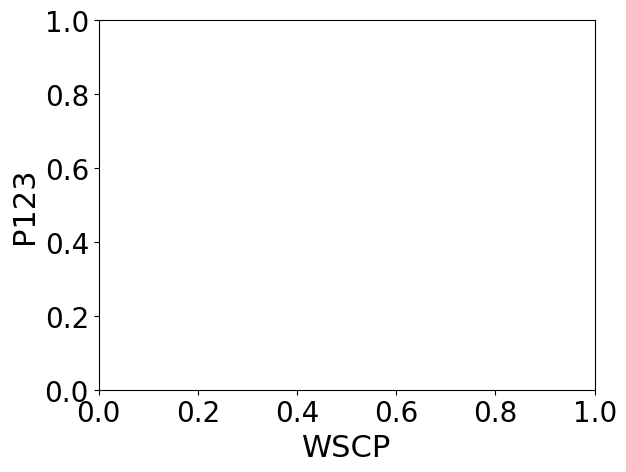

In [42]:
fig, ax = plt.subplots()
for k in range(n_clusters):
    Mk = result['delta_n']==k
    points = data.C[Mk,:]
    # Computing the alpha shape
    try:
        edges = alpha_shape(points, 
                            alpha=0.25, 
                            only_outer=True
                           )
        for i, j in edges:
            ax.plot(points[[i, j], 0], 
                    points[[i, j], 1],
                    color = color_blindf[k],
                   )
    except:
        print('Could not plot %d'%k)
        

ax.set_xlabel(saxs['C_dim_names'][0], fontsize=22)
ax.set_ylabel(saxs['C_dim_names'][1], fontsize=22)
ax.tick_params(labelsize=20)
plt.show()

In [44]:
edges

set()

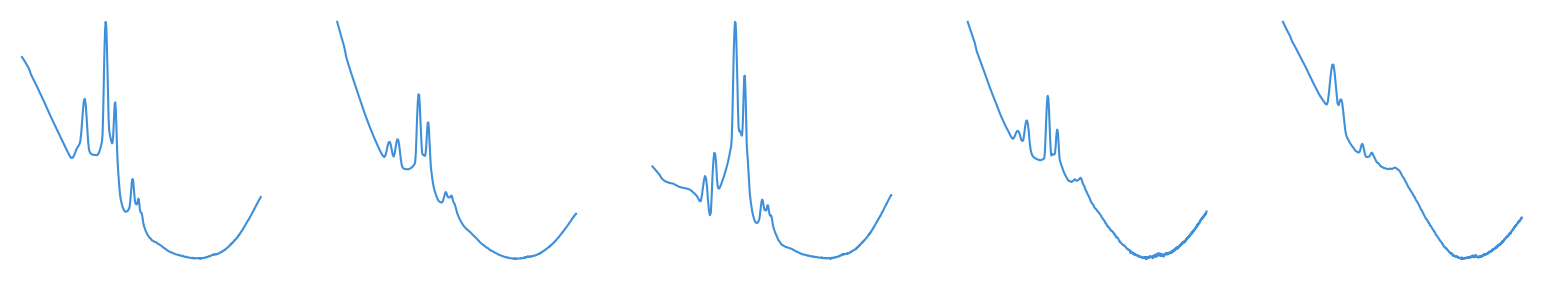

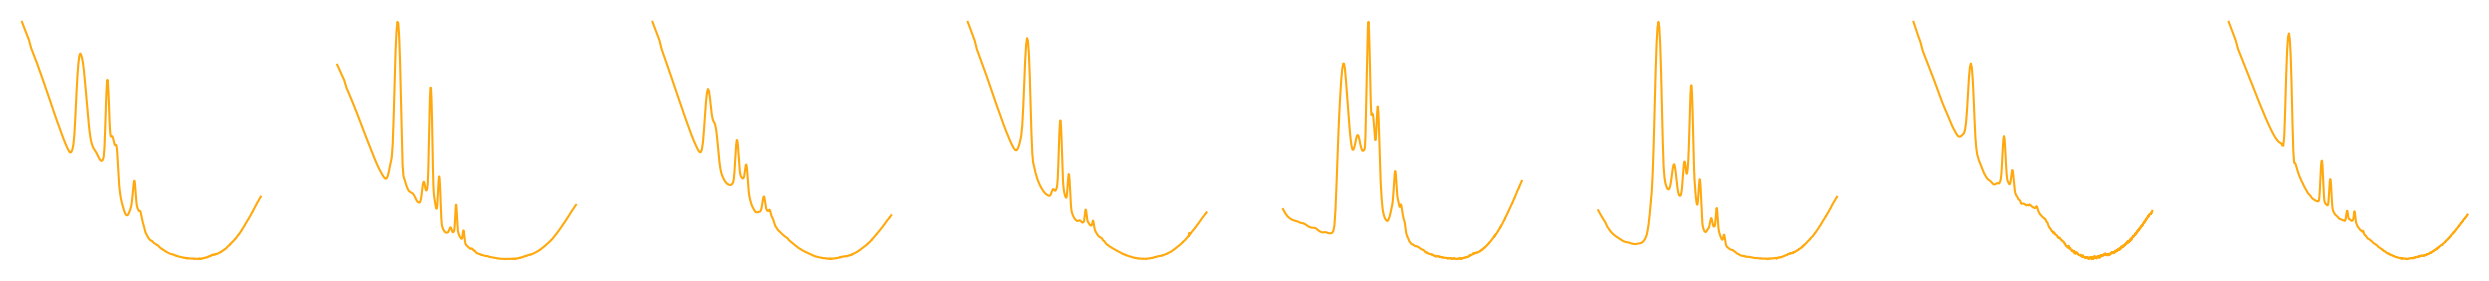

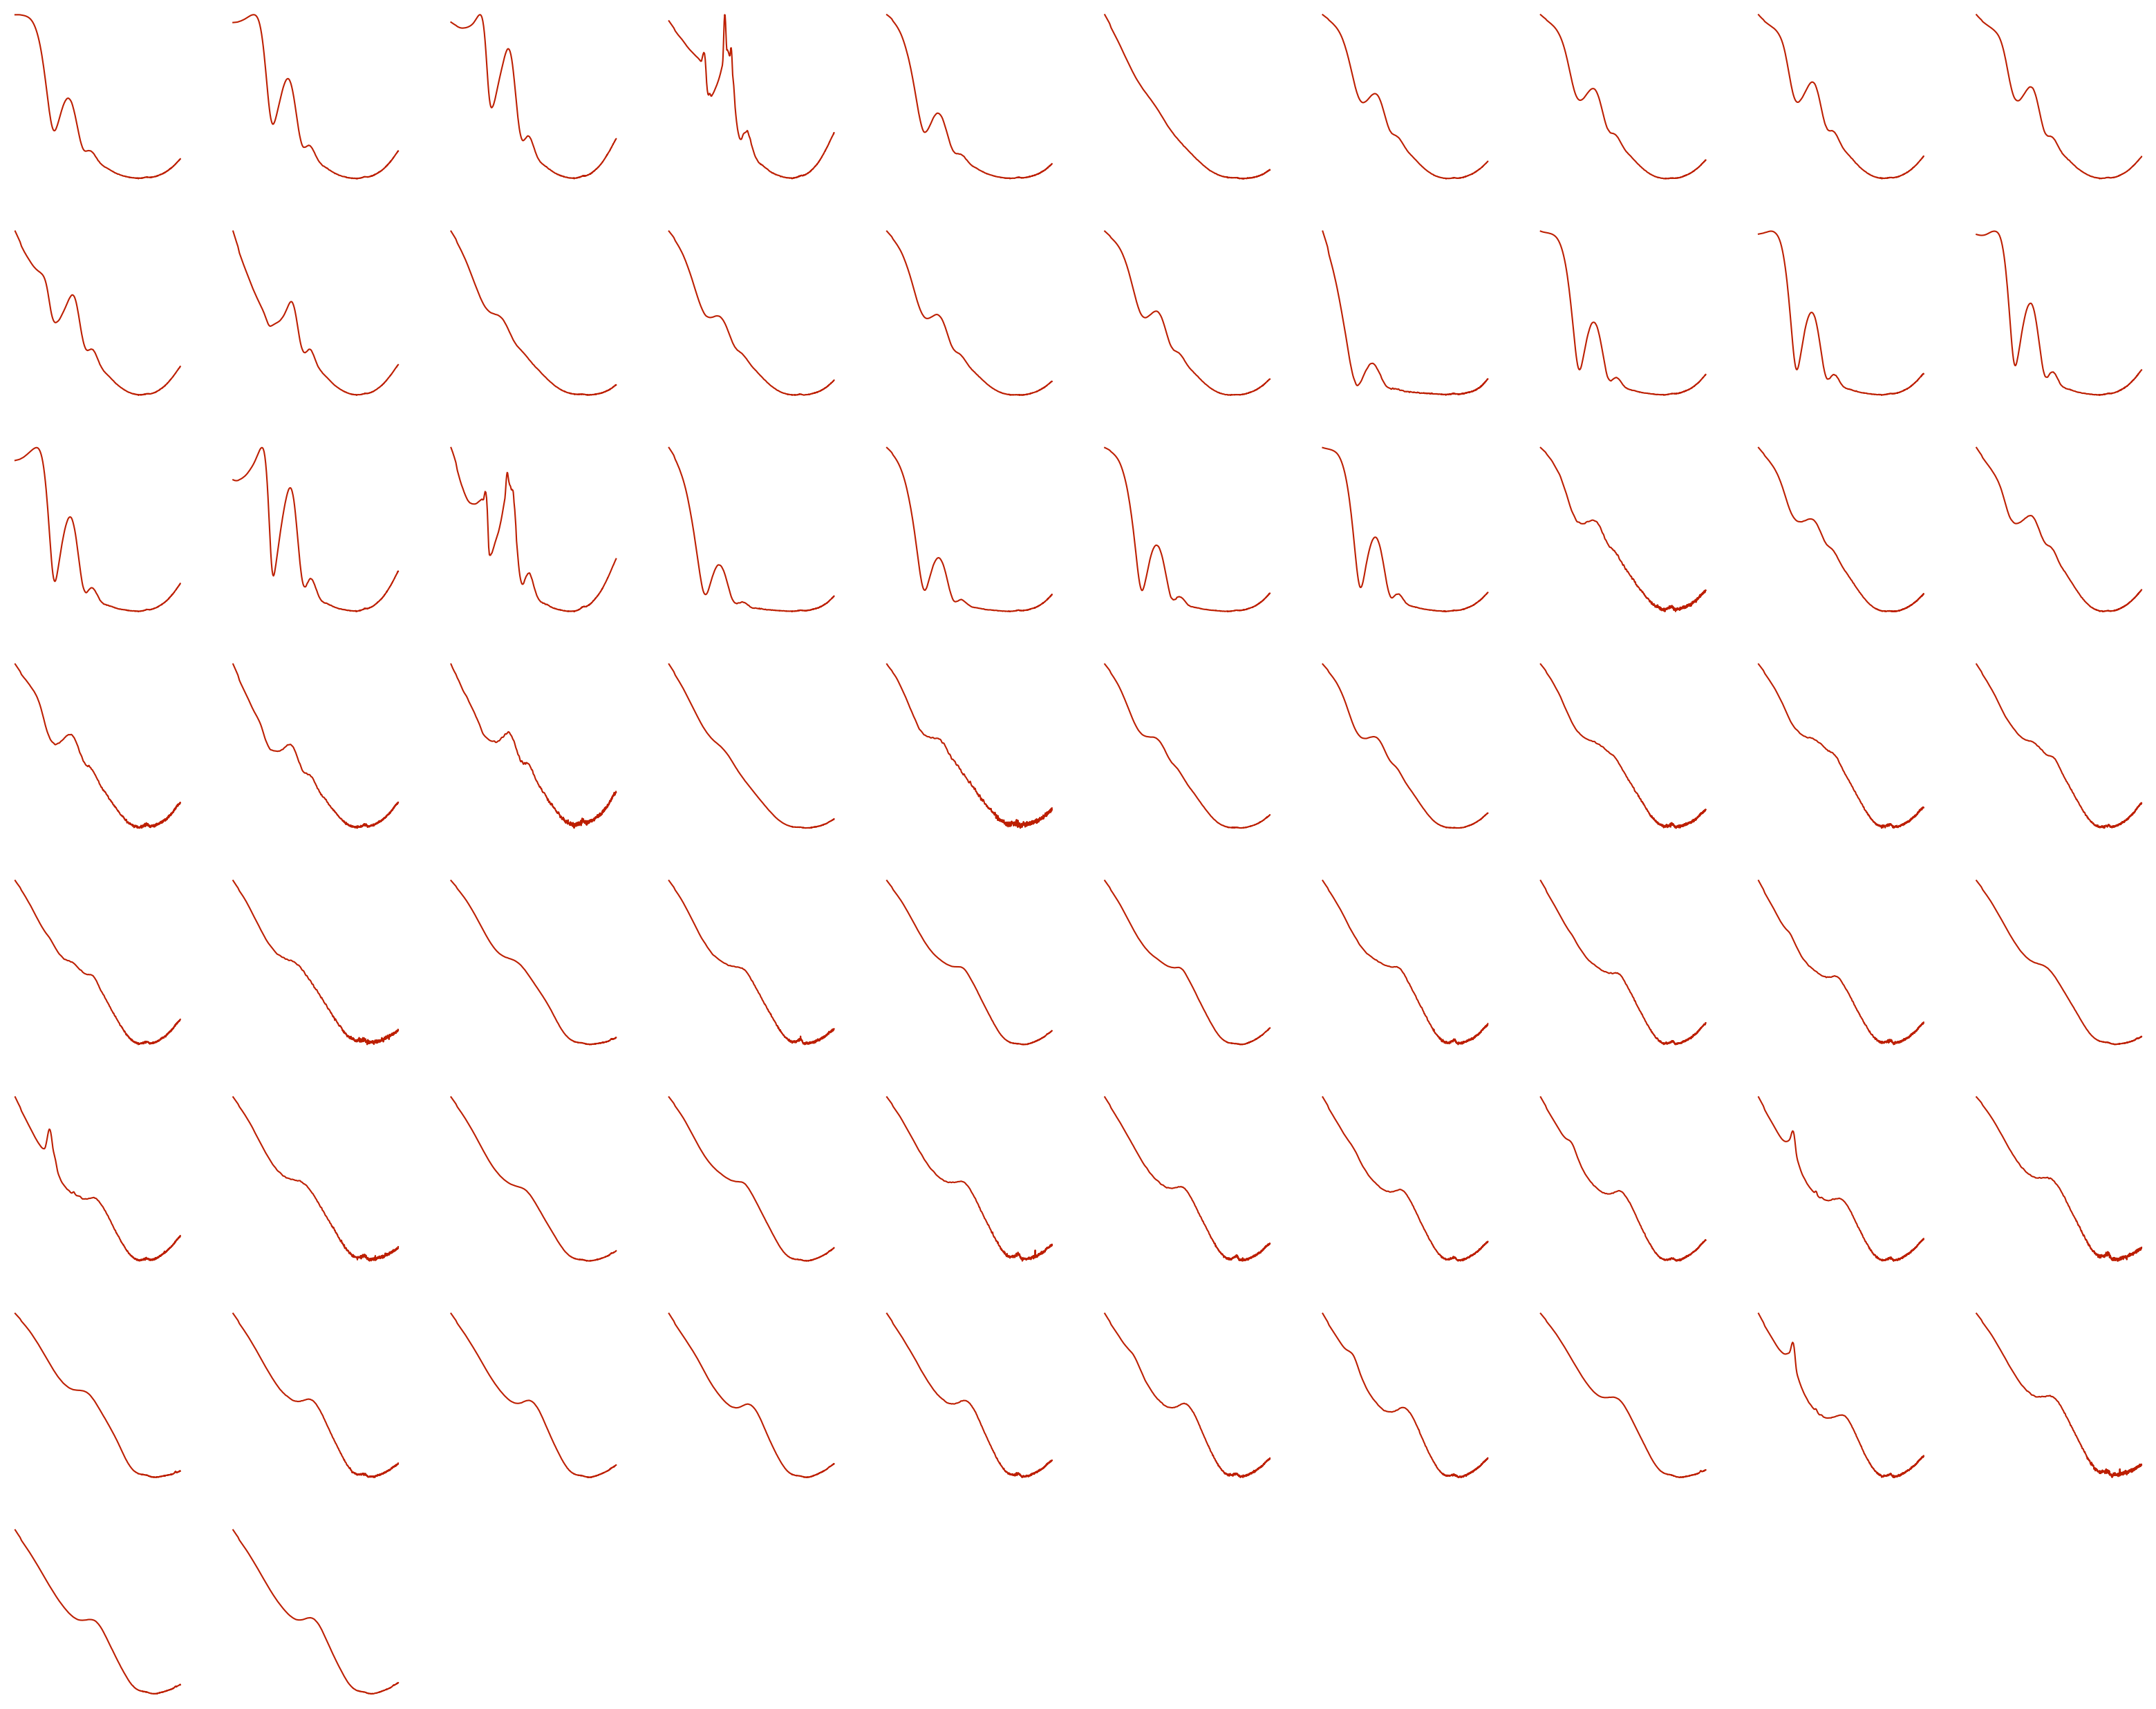

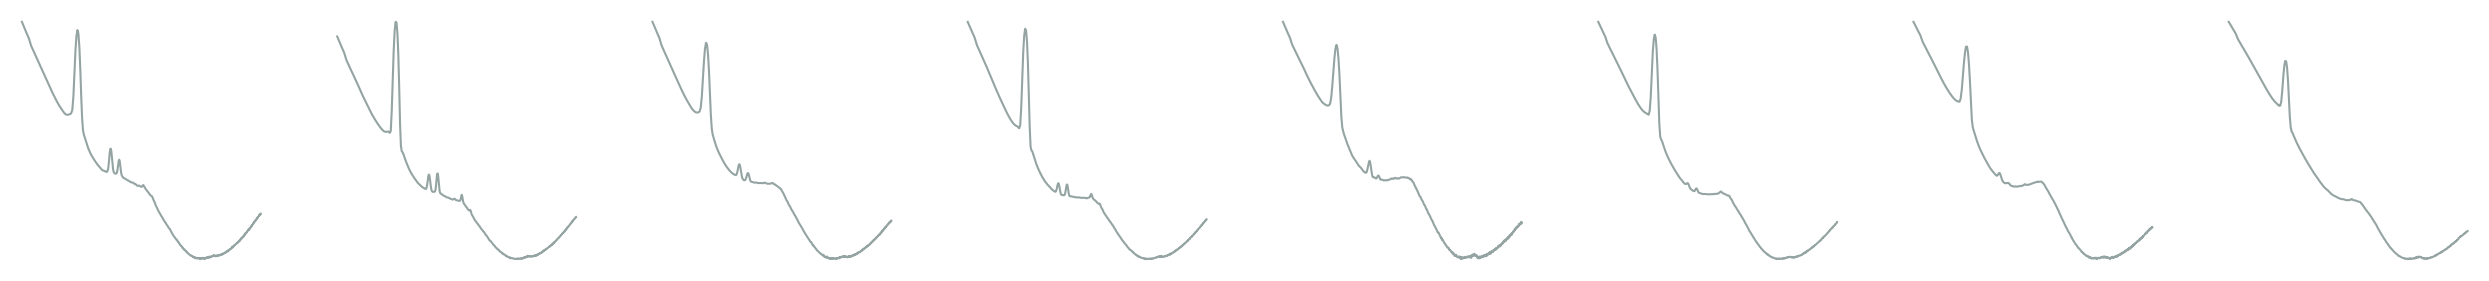

In [11]:
for k in range(n_clusters):
    Mk = np.argwhere(result["delta_n"]==k).squeeze()
    fig, axs = plt.subplots(10,10, figsize=(20*2, 20*2))
    axs = axs.flatten()
    num_plots = np.min([100, len(Mk)])
    [ax.remove() for ax in axs[num_plots:]]
    ax_ind = 0
    for i in Mk:
        ax = axs[ax_ind]
        ax.loglog(data.q, data.F[i], 
                    color=color_blindf[k]
                 )    
        ax.axis('off')
        ax_ind += 1
    plt.show()